
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2024.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/ahoust17/MLSTEM2024/main/Day1/Generate_Dataset.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day1/Generate_Dataset.ipynb)

# Making a Dataset for Training a Segmentation Model to Distinguish Atoms

**Speaker: Austin Houston**

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>

<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

## Load packages

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

In [ ]:
%matplotlib widget

import matplotlib.pylab as plt
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
    from  google.colab import drive 
    from google.colab import output
    output.enable_custom_widget_manager()

import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools 
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ', pyTEMlib.__version__)

## Do all of registration

notebook_tags= {'notebook': 'Image_Registration',
                'notebook_version': '2024_05_14',
                'pyTEM version': pyTEMlib.__version__}

print('installing DataGenSTEM')
!git clone https://github.com/ahoust17/DataGenSTEM.git

import secrets
from ase.io import read
from ase.visualize import view
from sklearn.model_selection import train_test_split

sys.path.append('./DataGenSTEM/DataGenSTEM')
import data_generator as dg

# Why Use Machine Learning?

### - Accuracy and Robustness
### - Low Signal-to-Noise Conditions
### - Multi-Class Segmentation
### - Where Atoms Overlap


### Read in the experimental data


In [ ]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    if not os.path.exists('./STO_Stack_10.dm3'):
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/STO_Stack_10.dm3
        
fileWidget = pyTEMlib.file_tools.FileWidget()

In [ ]:
datasets = fileWidget.datasets
dataset = fileWidget.selected_dataset
# dataset = datasets['Channel_000']
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image stack')
dataset.x.dimension_type = 'spatial'
dataset.y.dimension_type = 'spatial'
dataset.set_dimension
view = dataset.plot()

In [ ]:
# normalization
dataset -= np.min(dataset)
dataset /= np.max(dataset)

print('Shape:', dataset.shape)

pixel_size = dataset.original_metadata['BinaryResult']['PixelSize']['width']*10^10 # 'Angstrom/pixel'
print('Pixel size:', pixel_size, 'Angstrom/pixel')

## Main Idea: Simulated Data Must be Reasonably Similar to Experimental Data

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(dataset.flatten(), bins=256, range=[0, 1], density=True)
ax.set_xlabel('Normalized intensity')
fig.suptitle('Distribution of pixel values')

## Read in crystal structure

In [2]:
xtal = read('./DataGenSTEM/crystal_files/SrTiO3.cif') * (50,50,1)
# view(xtal, viewer='x3d')

## Define image bounds

In [4]:
# Define the image size in Angstroms
positions = xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)
pixel_size = 0.07 #pixel_size # Angstrom/pixel

### Make xtal (with random rotations and vacancies)

In [5]:
rotation = 0
phonon_sigma = 0.10
n_vacancies = 10

rot_xtal = dg.get_imaging_xtal(xtal = xtal, 
                              n_cells = (1,1,1), 
                              rotation = rotation, 
                              n_vacancies = n_vacancies, 
                              phonon_sigma = phonon_sigma, 
                              axis_extent = axis_extent)
# view(rot_xtal, viewer='x3d')

### Make scattering potential - sum of gaussians

(-0.5, 2794.5, 2794.5, -0.5)

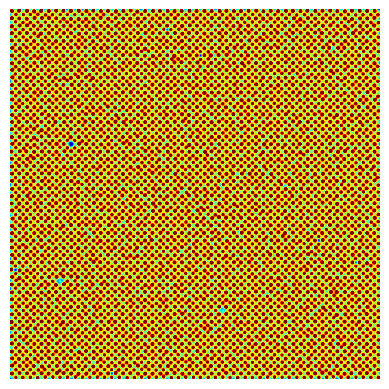

In [6]:
potential = dg.get_pseudo_potential(xtal = rot_xtal,
                                    pixel_size = pixel_size,
                                    sigma = 0.1,
                                    axis_extent = axis_extent,
                                    mode = 'gaussian')

fig, ax = plt.subplots(1, 1)
ax.imshow(potential, cmap='jet', vmin=0, vmax=0.5)
ax.axis('off')

### Simulate the beam - approximately
The shape of a beam which evenly illuminates a round apperture, due to diffraction, is an airy disk.

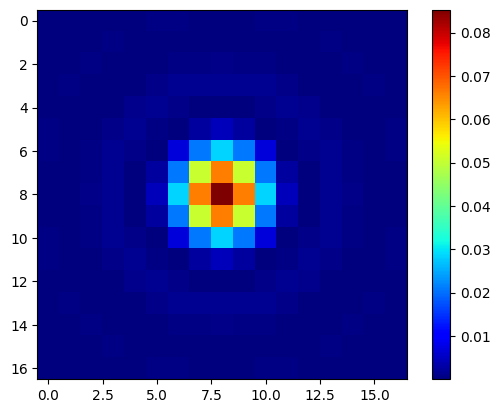

In [7]:
psf = dg.get_point_spread_function(airy_disk_radius = 1, size = 8)

fig, ax = plt.subplots(1, 1)
ax.imshow(psf, cmap='jet')
fig.colorbar(ax.imshow(psf, cmap='jet'), ax=ax)

### Case-specific for STO
The overlapping atoms complicate the categories of the labels

In [8]:
# Delete Oxygen Atoms
to_delete = []
for atom in rot_xtal:
    if atom.symbol == 'O':
        to_delete.append(atom.index)

mask_xtal = rot_xtal.copy()
del mask_xtal[to_delete]

### Make image, add shot noise, and make masks

In [9]:
# Image = Potential X PSF
perfect_image = dg.convolve_kernel(potential, psf)

# Add sampling noise (0 to 1)
count_statistics = 0.8
noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = count_statistics)

# Generate label masks - ground truths for training
masks = dg.get_masks(mask_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 8, mode='integer')

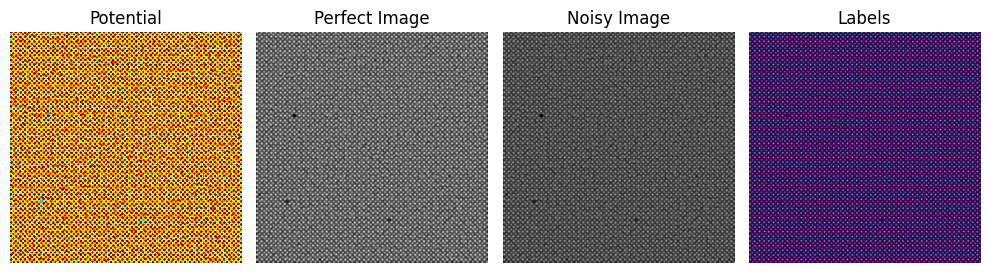

In [10]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 5))

ax[0].set_title('Potential')
ax[0].imshow(potential, cmap='jet', vmax=0.5)

ax[1].set_title('Perfect Image')
ax[1].imshow(perfect_image, cmap='gray')

ax[2].set_title('Noisy Image')
ax[2].imshow(noisy_image, cmap='gray')

ax[3].set_title('Labels')
ax[3].imshow(masks, cmap='viridis')

for ax in ax:
    ax.axis('off')
fig.tight_layout()


### Create a dataset by randomly cropping and magnifying the images and masks

In [11]:
# Crop and zoom
n_crops = 5
crop_size = 256
magnification_var = 0.3

batch_ims = dg.shotgun_crop(noisy_image, crop_size = crop_size, n_crops = n_crops, seed = 42, magnification_var = magnification_var, roi = 'middle')
batch_ims = batch_ims.reshape(-1,crop_size,crop_size)
print('Image shape:', batch_ims.shape)

batch_masks = dg.shotgun_crop(masks, crop_size = crop_size, n_crops = n_crops, seed = 42, magnification_var = magnification_var, return_binary = True, roi = 'middle')
print('Mask shape:', batch_masks.shape)


Image shape: (5, 256, 256)
Mask shape: (5, 256, 256)


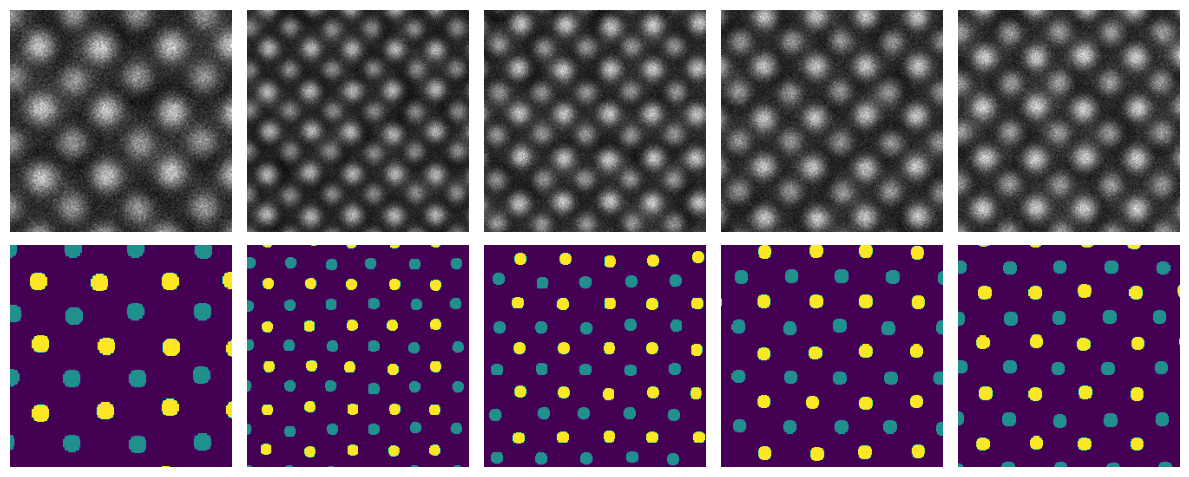

In [12]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 5))

for i, ax in enumerate(axs[0,:]):
    ax.imshow(batch_ims[i], cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axs[1,:]):
    ax.imshow(batch_masks[i], cmap='viridis')
    ax.axis('off')

fig.tight_layout()


### Now we put it all together!

In [13]:
# Generate training dataset
n_images = 200
crop_size = 256
pixel_size = pixel_size # Angstrom/pixel
n_crops = 20 # per image

print('reading xtal:')
xtal = read('./DataGenSTEM/crystal_files/SrTiO3.cif') * (50,50,1)
positions = xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)


image_counter = 0
master_images = np.zeros((n_images, crop_size, crop_size))
master_labels = np.zeros((n_images, crop_size, crop_size))

print('making images:')
while image_counter < n_images:
    master_seed = secrets.randbits(128)
    rng = np.random.default_rng(master_seed)

    # Set random params
    # --------------------------------------------------
    phonon_sigma = rng.uniform(0.05, 0.10)
    rotation = rng.uniform(0,360)
    atom_var = rng.normal(loc = 0.1, scale = 0.01)
    airy_disk_size = 1
    shot_noise = rng.uniform(0.6, 0.9)
    magnification_var = rng.uniform(0.2, 0.35)
    crop_param_seed = rng.integers(0, 1000000)
    # --------------------------------------------------

    rot_xtal = dg.get_imaging_xtal(xtal = xtal, 
                                n_cells = (1,1,1), 
                                rotation = rotation, 
                                n_vacancies = 10, 
                                phonon_sigma = phonon_sigma, 
                                axis_extent = axis_extent)

    potential = dg.get_pseudo_potential(xtal = rot_xtal,
                                        pixel_size = pixel_size,
                                        sigma = atom_var,
                                        axis_extent = axis_extent)
    potential /= np.max(potential)

    psf = dg.get_point_spread_function(airy_disk_radius = airy_disk_size, size = 8)

    # Delete Oxygen Atoms
    to_delete = []
    for atom in rot_xtal:
        if atom.symbol == 'O':
            to_delete.append(atom.index)

    mask_xtal = rot_xtal.copy()
    del mask_xtal[to_delete]

    perfect_image = dg.convolve_kernel(potential, psf)
    noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = shot_noise)
    masks = dg.get_masks(mask_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 8, mode='integer')

    batch_ims = dg.shotgun_crop(noisy_image, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, roi = 'middle')
    batch_ims = batch_ims.reshape(-1,crop_size,crop_size)
    batch_masks = dg.shotgun_crop(masks, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')

    # Process batch images and masks
    for i, (image, mask) in enumerate(zip(batch_ims, batch_masks)):
        image = image - np.min(image)
        image = image / np.max(image)
        master_images[image_counter] = image
        master_labels[image_counter] = mask
        image_counter += 1
        print(f'Image {image_counter}/{n_images}', end='\r')

print('done!')
X_train, X_test, y_train, y_test = train_test_split(master_images, master_labels, test_size=0.2, random_state=42)
np.savez('training_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

reading xtal:
making images:
done! 200/200
